In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pylab as plt
# import vision.sim_tools.connectors.kernel_connectors as kconn
from vision.spike_tools.vis import my_imshow, plot_spikes
# from vision.sim_tools.vis import plot_connector_3d
# import vision.sim_tools.kernels.center_surround as csgen
# import vision.sim_tools.kernels.gabor as gabgen

from mpl_toolkits.mplot3d import axes3d, Axes3D

from vision.retina import Retina, dvs_modes, MERGED
from vision.spike_tools.pattern import pattern_generator as pat_gen

from pyNN import nest as sim


def setup_cam_pop(sim, spike_array, img_w, img_h, w2s=1.6):
    pop_size = img_w*img_h*2
    cell = sim.IF_curr_exp
    params = { 'cm': 0.2,  # nF
               'i_offset': 0.0,
               'tau_m': 10.0,
               'tau_refrac': 2.0,
               'tau_syn_E': 1.,
               'tau_syn_I': 1.,
               'v_reset': -70.0,
               'v_rest': -65.0,
               'v_thresh': -55.4
             }
    cam_pop = sim.Population(pop_size, cell, params,
                             label='camera')
    dmy_pops = []
    dmy_prjs = []
    for i in range(pop_size):
        dmy_pops.append(sim.Population(1, cell, params,
                                       label='pixel (row, col) = (%d, %d)'%\
                                       (i//img_w, i%img_w)))
        conn = [(0, i, w2s, 1)]
        dmy_prjs.append(sim.Projection(dmy_pops[i], cam_pop,
                                       sim.FromListConnector(conn),
                                       target='excitatory'))
    
    return cam_pop, dmy_pops, dmy_prjs



('max_y ', None)


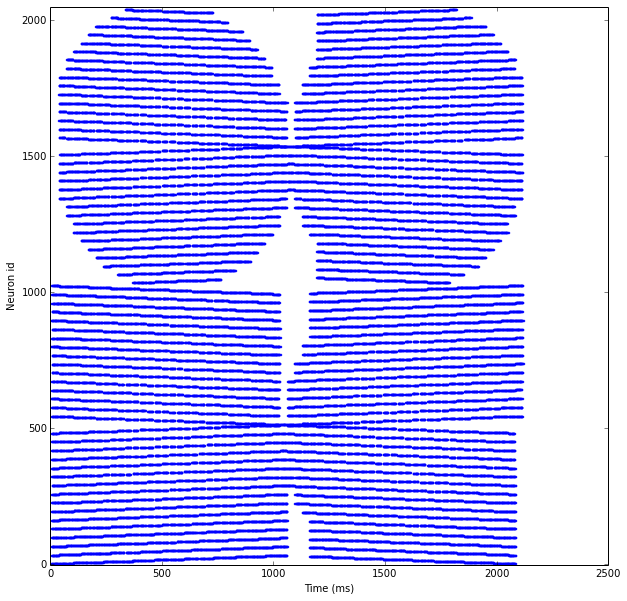

In [2]:
img_w, img_h = 16, 16
num_neurons = img_w*img_h*2
fps = 30
frames = 32
thresh = 25
deg = 0
dx = 1.
'''spikes_pol_MERGED_enc_RATE_
   thresh_25_hist_99_
   inh_False___
   64_frames_at_
   30fps_
   32x32_res_spikes
'''
on_time_ms  = frames*(1000./fps)
off_time_ms = 0
start_time  = 10
spikes_dir = './moving_bar_spikes/deg_%d___dx_%f'%(deg, dx)
spikes = pat_gen.img_spikes_from_to(spikes_dir, num_neurons, 0, 1, 
                                    on_time_ms, off_time_ms,
                                    start_time)


fig = plt.figure(figsize=(10, 10))
plot_spikes(spikes)
plt.show()

In [3]:

sim.setup(timestep=1., max_delay=12., min_delay=1.)

cam, ssa_cam, prj_cam = setup_cam_pop(sim, spikes, 
                                      img_w, img_h, w2s=1.6)

cfg = {'record': {'voltages': False, 
                  'spikes': True,
                  'weights': False
                 },
      }
mode = dvs_modes[MERGED]
retina = Retina(sim, cam, img_w, img_h, mode, cfg=cfg)

run_time = 2500
sim.run(2500)

out_spks = {}
for k in retina.pops.keys():
    for p in retina.pops[k].keys():
        key = "%s__%s"%(k, p)
        try:
            out_spks[key] = retina.pops[k][p].getSpikes(compatible_output=True)
        except:
            print("no spikes for population %s"%(key))

sim.end()

no spikes for population on
no spikes for population on
no spikes for population on
no spikes for population on
no spikes for population on
no spikes for population on
no spikes for population on
no spikes for population off
no spikes for population off
no spikes for population off
no spikes for population off
no spikes for population off
no spikes for population off
no spikes for population off
